# Thermochromic IGU simulation with pywincalc

In [2]:
import pywincalc
import requests
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pytz
import datetime
import pysolar
from importlib.metadata import version   
from epw import epw
import pickle
import pandas as pd
import scipy.optimize as opt
import copy

/Users/andymcneil/Documents/IRDynamics/ThermochromicSimulation/pyenv_thermochromic/lib/python3.12/site-packages/epw/__init__.py:23: UserWarning: The epw.data submodule is not installed
  warnings.warn("The epw.data submodule is not installed")


## Load Thermochromic Product Data & Plot Spectral Transmission

In [2]:
# Get thermocromic product spectral data from files
S05C = pywincalc.parse_optics_file("product_data/Suntuitive_05C.txt")
S15C = pywincalc.parse_optics_file("product_data/Suntuitive_15C.txt")
S25C = pywincalc.parse_optics_file("product_data/Suntuitive_25C.txt")
S45C = pywincalc.parse_optics_file("product_data/Suntuitive_45C.txt")
S65C = pywincalc.parse_optics_file("product_data/Suntuitive_65C.txt")
S85C = pywincalc.parse_optics_file("product_data/Suntuitive_85C.txt")
S95C = pywincalc.parse_optics_file("product_data/Suntuitive_95C.txt")

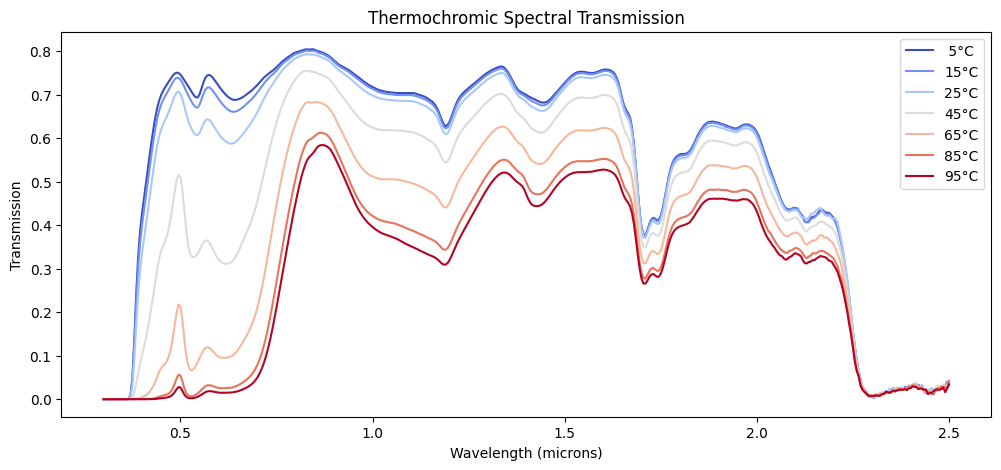

In [3]:
#Create a spectral dataframe with the wavelengths from the product data
wavelength = []
for wavelen in S05C.measurements:
    wavelength.append(wavelen.wavelength)
spectra_df = pd.DataFrame(wavelength, columns=['wavelength'] )

#add spectral transmission data for each suntuitive temperature to the data frame
for layer_temp in [ S05C, S15C, S25C, S45C, S65C, S85C, S95C ]:
    spectra = []
    for wavelen in layer_temp.measurements:
        spectra.append(wavelen.direct_component.transmittance_front)
    spectra_df.insert(spectra_df.shape[1], int(layer_temp.product_name[11:13]), spectra, True)
spectra_df = spectra_df.set_index('wavelength')

#create a blue-red color gradient for the plot lines
cmap = plt.cm.coolwarm
plot_colors = list(cmap(np.linspace(0,1, spectra_df.shape[1])))

#plot the spectral data frame
spectra_df.plot(
    xlabel='Wavelength (microns)',
    ylabel='Transmission',
    title='Thermochromic Spectral Transmission',
    figsize=[12,5],
    color=plot_colors
)
plt.legend([' 5°C', '15°C', '25°C', '45°C', '65°C', '85°C', '95°C'])
plt.show()

## Dowload Low-e coated interior lites
### build glazing systems and calculate IGU performance

In [4]:
# URL and Access Token for LBNL's IGSDB
# This is taken directly from LBNL's example
url_single_product = "https://igsdb.lbl.gov/api/v1/products/{id}"  # Template URL for single product
url_single_product_datafile = "https://igsdb.lbl.gov/api/v1/products/{id}/datafile"  # Template URL for getting data file for a product

# Here I'm loading my API key from a file
# This igsdb.json file contents are as follows:
# {
#   "Authorization": "Token <<secret key goes here>>"
# }
# Contact LBNL to get your own login and generate your key
# https://igsdb.lbl.gov/about/ 
with open('/Users/andymcneil/.keys/igsdb.json') as f:
    headers = json.load(f)

In [5]:
# Download product data from the IGSDB.
interior_lites = [
    [ 5054, 'Cardinal_LoE180'],
    [ 3750, 'Cardinal_LoE272'],
    [ 3760, 'Cardinal_LoE376']
]

for i in range(len(interior_lites)):    
    igsdb_id = interior_lites[i][0]
    igsdb_response = requests.get(url_single_product.format(id=igsdb_id),headers=headers)
    interior_lites[i].append(pywincalc.parse_json(igsdb_response.content))

Cardinal_LoE180 = interior_lites[0][2]
Cardinal_LoE272 = interior_lites[1][2]
Cardinal_LoE376 = interior_lites[2][2]

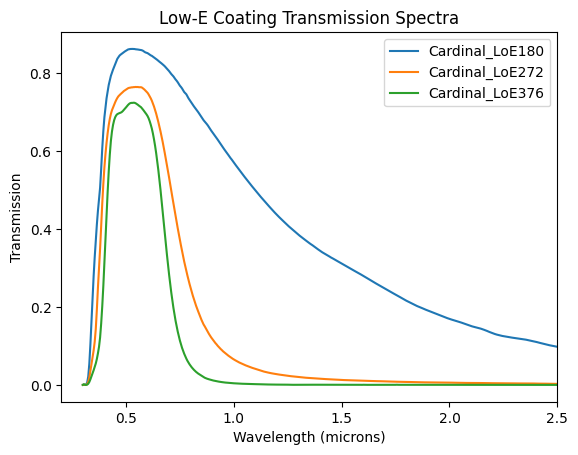

In [6]:
legend = []
for i in range(len(interior_lites)):
    this_spectra = []
    this_wavelength = []
    for wavelength in interior_lites[i][2].measurements:
        this_wavelength.append(wavelength.wavelength)
        this_spectra.append(wavelength.direct_component.transmittance_front)
    legend.append(interior_lites[i][1])
    plt.plot(this_wavelength,this_spectra)
    
plt.xlabel("Wavelength (microns)")  
plt.ylabel("Transmission")
plt.xlim(.2,2.5)
plt.legend(legend)
plt.title("Low-E Coating Transmission Spectra")
plt.show()

In [7]:
# defining a 1/2" 90% Argon gap
gas_argon90 = pywincalc.create_gas(
    [
        [0.9, pywincalc.PredefinedGasType.ARGON],
        [0.1, pywincalc.PredefinedGasType.AIR]
    ])
gap_127argon90 = pywincalc.Layers.gap(thickness=.0127, gas=gas_argon90)

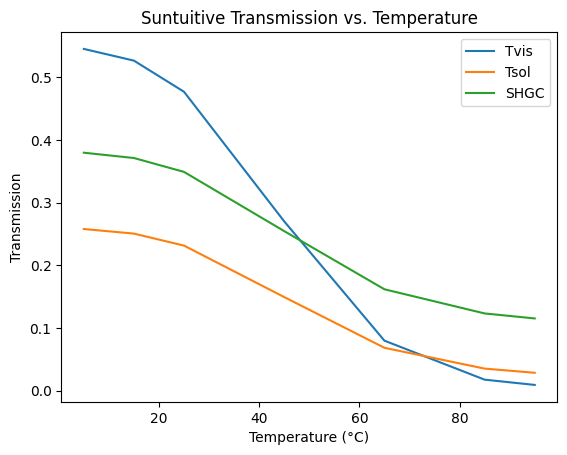

In [8]:
#create a data frame for product performance
product_df = pd.DataFrame(columns=['Product Name', 'Tvis', 'Tsol', 'SHGC', 'Suntuitive Temp'])

# Set interior lite product
interior_lite = Cardinal_LoE272

#fill data frame with spectral data
for layer_temp in [ S05C, S15C, S25C, S45C, S65C, S85C, S95C ] :
    #create a glazing system with suntuitive laminate as exterior and low-e glass as interior lite
    glazing_system = pywincalc.GlazingSystem(environment=pywincalc.nfrc_shgc_environments(),
                                             solid_layers=[layer_temp, interior_lite],
                                             gap_layers=[gap_127argon90]
                                            )
    #flip the interior lite if the low emissivity layer is not on the front
    if interior_lite.emissivity_front > 0.3:
        glazing_system.flip_layer(1,True)

    #calculate visible and solar transmission
    photopic = glazing_system.optical_method_results("PHOTOPIC")
    solar = glazing_system.optical_method_results("SOLAR")

    #calculate SHGC
    shgc = glazing_system.shgc()

    #calculate layer temperatures
    glazing_system.u(1,1) # needed to include sun in temperature calculation (bug work around)
    temperatures = glazing_system.layer_temperatures(pywincalc.TarcogSystemType.SHGC)

    #average surface 1 and surface 2 temperatures, and conver to °C
    suntuitive_temp = (temperatures[0] + temperatures[1])/2 - 273.15

    
    product_df.loc[len(product_df)] = [ layer_temp.product_name,
                           photopic.system_results.front.transmittance.direct_direct,
                           solar.system_results.front.transmittance.direct_direct,
                           shgc,
                           suntuitive_temp
                         ]

#Add temperature and set temperature as the index
product_df.insert(0, 'Temperature (°C)', [5, 15, 25, 45, 65, 85, 95])
product_df = product_df.set_index('Temperature (°C)')

#plot product performance data agains temperature
product_df[['Tvis','Tsol','SHGC']].plot(
    title='Suntuitive Transmission vs. Temperature',
    ylabel='Transmission'
               )
plt.show()

In [9]:
product_df

,Product Name,Tvis,Tsol,SHGC,Suntuitive Temp
Temperature (°C),,,,,
5,Suntuitive_05C,0.545470,0.257930,0.379767,44.458228
15,Suntuitive_15C,0.526796,0.250619,0.371297,44.976770
25,Suntuitive_25C,0.477030,0.231439,0.349132,46.309784
45,Suntuitive_45C,0.270114,0.149270,0.254553,51.969172
65,Suntuitive_65C,0.079666,0.068288,0.161719,57.847610
85,Suntuitive_85C,0.017417,0.035071,0.123140,60.937317
95,Suntuitive_95C,0.009017,0.028403,0.115156,61.731960


## Determine equilibrium temperature at NFRC Summer conditions
SHGC is calculated for a specific environmental condition:
* Exterior Temperature: 32°C
* Interior Temperature: 24°C
* Incident Solar Radiation: 783 W/m2
* Solar Incident Angle: 0° (normal incidence)
* Wind Speed: 2.75 m/s
* Wind Direction relative to facade: Windward

We calculated SHGC with optical properties measured at temperatures ranging from 0-95°C. However at NFRC summer conditions the suntuitave laminate will stabalize at one temperature with optical properties at that temperature. SHGC for all other temperatures is meaningless. We can use the calculated layer temperatures to determine where that equilibrium occurs.

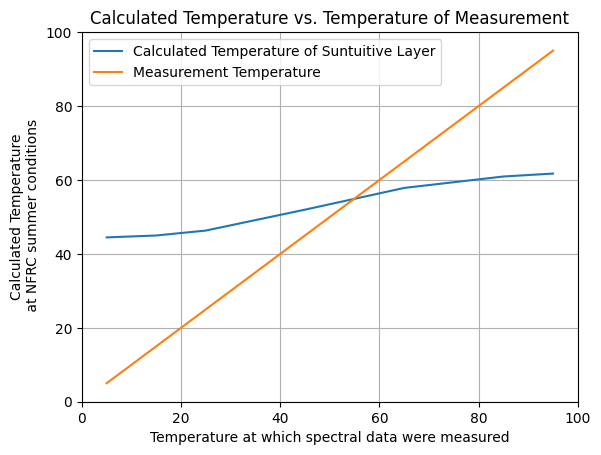

In [10]:
# Plotting calculated temperature vs. measured temperature
temp_df = product_df.copy(deep=True)
temp_df.insert(temp_df.shape[1], 'Measurement Temperature', [5,15,25,45,65,85,95])
temp_df[['Suntuitive Temp', 'Measurement Temperature']].plot(
    title='Calculated Temperature vs. Temperature of Measurement',
    ylabel='Calculated Temperature\n at NFRC summer conditions',
    xlabel='Temperature at which spectral data were measured',
    ylim=[0,100],
    xlim=[0,100],
    grid=True
)
plt.legend(['Calculated Temperature of Suntuitive Layer', 'Measurement Temperature'])
plt.show()

The equilibrium temperature is between 45C and 65°C where the lines cross

In [11]:
product_df[['Suntuitive Temp']].loc[[45,65]]

,Suntuitive Temp
Temperature (°C),
45,51.969172
65,57.847610


## Interpolate between measured temperatures
Using piecewise linear interpolation to fill in between measured tint states.

In [12]:
# Create a data frame for transmission, reflection front, and reflection back
wavelength = []
for wavelen in layer_temp.measurements:
    wavelength.append(wavelen.wavelength)
transmission_df = pd.DataFrame(wavelength, columns=['wavelength'] )
reflectionfront_df = pd.DataFrame(wavelength, columns=['wavelength'] )
reflectionback_df = pd.DataFrame(wavelength, columns=['wavelength'] )

#add spectral transmission data for each suntuitive temperature to the data frame
for layer_temp in [ S05C, S15C, S25C, S45C, S65C, S85C, S95C ]:
    transmission_ar = []
    reflectionfront_ar = []
    reflectionback_ar = []
    for wavelen in layer_temp.measurements:
        transmission_ar.append(wavelen.direct_component.transmittance_front)
        reflectionfront_ar.append(wavelen.direct_component.reflectance_front)
        reflectionback_ar.append(wavelen.direct_component.reflectance_back)
    transmission_df.insert(transmission_df.shape[1], int(layer_temp.product_name[11:13]), transmission_ar, True)
    reflectionfront_df.insert(reflectionfront_df.shape[1], int(layer_temp.product_name[11:13]), reflectionfront_ar, True)
    reflectionback_df.insert(reflectionback_df.shape[1], int(layer_temp.product_name[11:13]), reflectionback_ar, True)


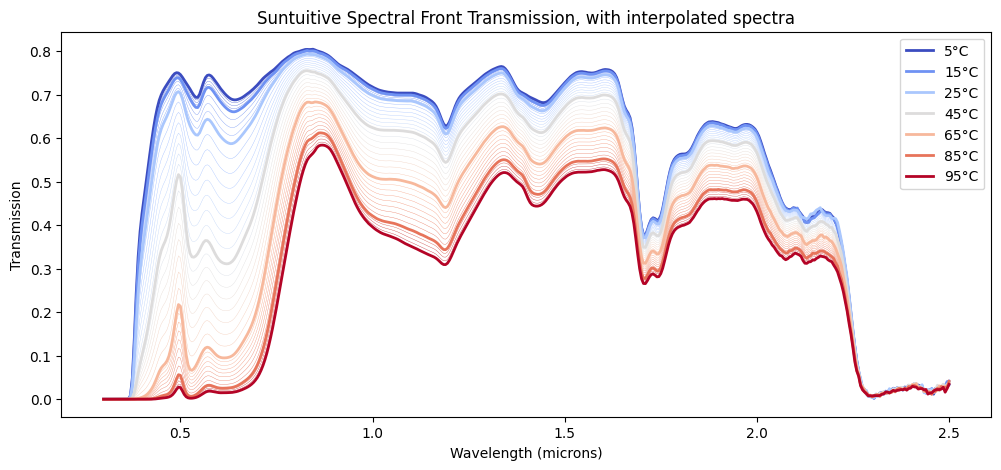

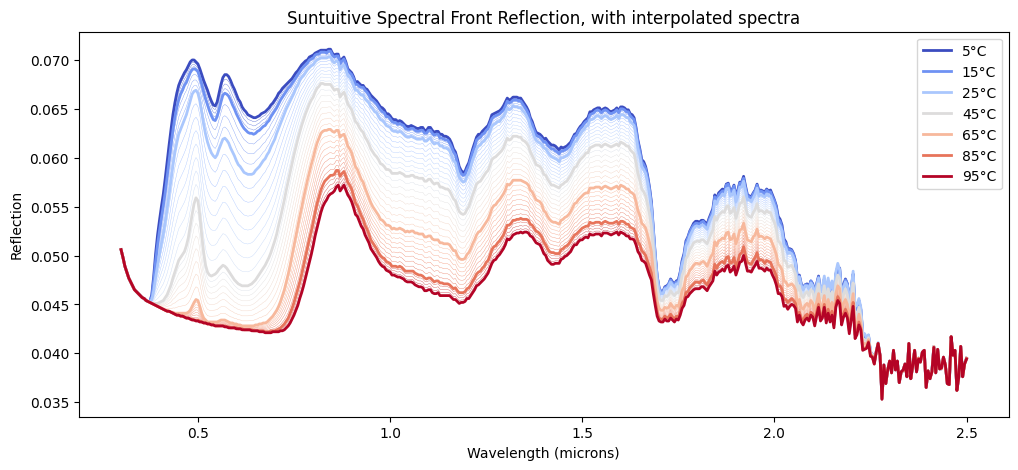

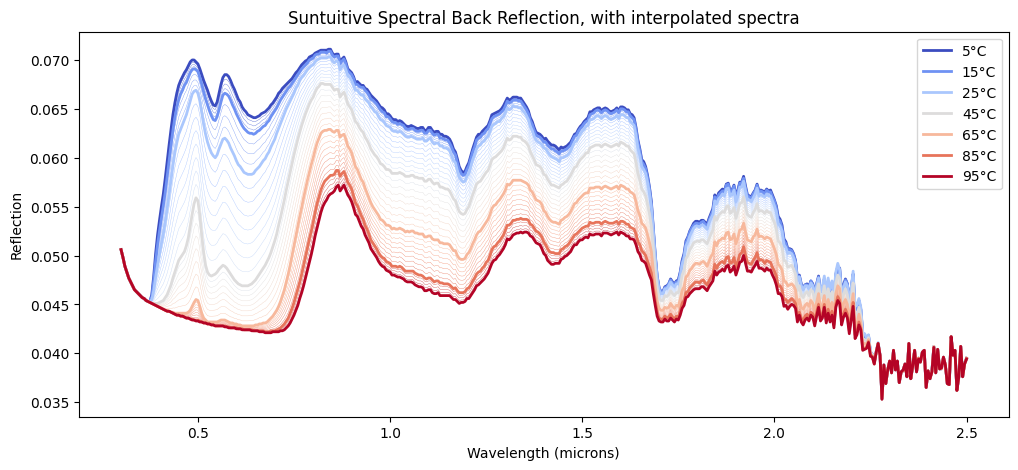

In [13]:
# generate a list of temperatures in 2.5 degree increments from 5°C to 95°C
between_temps = [ (j+2)*2.5 for j in range(37)]

# remove the temperatures we have optical properties for from the list
for k in [5,15,25,45,65,85,95]:
    between_temps.remove(k)

# create a list of spectral dataframes to iterate through
spectral_dataframes = [transmission_df, reflectionfront_df, reflectionback_df]
for itr, this_df in enumerate(spectral_dataframes) :
    #set wavelength as index and then transpose so wavelengths are columns and rows are temperatures
    this_df = this_df.set_index('wavelength').transpose()
    #add rows for additional temps with nan values
    for i in between_temps:
        this_df.loc[i] = [ np.nan for i in range(441)]
    #sort rows by temperature, interpolate rows, and transpose back to original
    this_df = this_df.sort_index()
    this_df = this_df.interpolate()
    this_df = this_df.transpose()

    ### Plot interpolated spectral lines
    #create a blue-red color gradient for the plot lines
    cmap = plt.cm.coolwarm
    plot_colors = list(cmap(np.linspace(0,1, this_df.shape[1])))

    meas_type = 'Transmission' if itr==0 else 'Reflection'
    meas_direction = 'Back' if itr==2 else 'Front'
    
    #plot the interpolated spectral data frame
    ax = this_df.plot(
        xlabel='Wavelength (microns)',
        ylabel=meas_type,
        title=f'Suntuitive Spectral {meas_direction} {meas_type}, with interpolated spectra',
        figsize=[12,5],
        color=plot_colors,
        linewidth=0.25,
    )

    #add measured temperatures as thick lines
    measured_temps = [5,15,25,45,65,85,95]
    cmap = plt.cm.coolwarm
    plot_colors = list(cmap(np.linspace(0,1, len(measured_temps))))
    for m in range(len(measured_temps)):
        plt.plot(this_df[[measured_temps[m]]], label=f'{measured_temps[m]}°C', color=plot_colors[m], linewidth=2)
    plt.legend()
    
    # Remove labels for interpolated data from the legend (too many entries in legend if all lines are included).
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[-len(measured_temps):], labels[-len(measured_temps):])
    plt.show()

    spectral_dataframes[itr]=this_df

### Creating a list of thermochromic optical properties in 2.5°C increments

In [14]:
#List of wavelengths and optical temperatures from spectra_dataframe for iterating to create optical properties
wavelengths = list(spectral_dataframes[0].index)
thermochromic_temperature_list = list(spectral_dataframes[0].columns)

#Empty list for appending produt optical data
thermochromic_layer_list = []

#Thickness and conductivity for thermochromic laminate
thickness = S05C.thickness /1000
conductivity = S05C.conductivity

#generating wavelength data and pywincalc.productdata objects for each thermochromic temperature
for this_temperature in thermochromic_temperature_list:
    pywincalc_wavelength_data = []
    for this_wavelength in wavelengths:
        direct_component = pywincalc.OpticalMeasurementComponent(
            spectral_dataframes[0].at[this_wavelength, this_temperature],
            spectral_dataframes[0].at[this_wavelength, this_temperature],
            spectral_dataframes[1].at[this_wavelength, this_temperature],
            spectral_dataframes[2].at[this_wavelength, this_temperature],
        )
        pywincalc_wavelength_data.append(pywincalc.WavelengthData(this_wavelength, direct_component))

    glass_n_band_optical_data = pywincalc.ProductDataOpticalNBand(
        material_type=pywincalc.MaterialType.LAMINATE,
        thickness_meters=thickness,
        wavelength_data=pywincalc_wavelength_data,
        coated_side=pywincalc.CoatedSide.NEITHER,
        ir_transmittance_front=0,
        ir_transmittance_back=0,
        emissivity_front=0.84,
        emissivity_back=0.84,
    )

    glass_thermal = pywincalc.ProductDataThermal(
        conductivity=conductivity,
        thickness_meters=thickness,
    )

    # Create a glass layer from both the optical and thermal data
    thermochromic_layer_list.append(pywincalc.ProductDataOpticalAndThermal(glass_n_band_optical_data,
                                                             glass_thermal))

### Define helper functions

In [15]:
# A function to generate pywincalc environments
def generate_environment(exterior_temperature, wind_speed, wind_direction, direct_solar_radiation):
    #set interior temperature based on exterior temperature.
    if exterior_temperature<20:
        interior_temperature = 20 # if exterior is below 20, inteior is 20
    elif exterior_temperature>24:
        interior_temperature = 24 # if exterior is above 24, interior is 24
    else:
        interior_temperature = exterior_temperature # if exterior is between 20 and 24, interior=exterior
    
    inside_environment = pywincalc.Environment(
            air_temperature = interior_temperature + 273.15,
            pressure = 101325.0,
            convection_coefficient = 0.0,
            coefficient_model = pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
            radiation_temperature = interior_temperature + 273.15,
            emissivity = 1.0,
            air_speed = 0.0,
            air_direction = pywincalc.AirHorizontalDirection.NONE,
            direct_solar_radiation = 0.0
        )

    outside_environment = pywincalc.Environment(
            air_temperature = exterior_temperature + 273.15,
            pressure = 101325.0,
            convection_coefficient = 26.0,
            coefficient_model = pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
            radiation_temperature = exterior_temperature + 273.15,
            emissivity = 1.0,
            air_speed = wind_speed,
            air_direction = wind_direction,
            direct_solar_radiation = direct_solar_radiation
        )

    custom_environmental_conditions = pywincalc.Environments(outside_environment, inside_environment)

    return(custom_environmental_conditions)

# a function to find the thermochromic equilibrium and report the thermochrimic 
# laminate temperature, and tvis, tsol and SHGC for the IGU
def determine_thermochromic_conditions(pywincalc_environment, thermochromic_temperature_list, thermochromic_layer_list, interior_lite, gap):
    # make local copies of the lists so that we can remove elements without affecting the list outside the function
    local_thermochromic_temperature_list = copy.deepcopy(thermochromic_temperature_list)
    local_thermochromic_layer_list = [ j for j in thermochromic_layer_list ]

    # remove entries where the thermochromic temperature is more than 2.5°C below the exterior 
    # temperature (to save unnecessary calculations)
    exterior_temperature = pywincalc_environment.outside.air_temperature - 273.15
    for temperature in thermochromic_temperature_list:
        if temperature + 2.5 < exterior_temperature:
            local_thermochromic_temperature_list.pop(0)
            local_thermochromic_layer_list.pop(0)
        else:
            break

    # create empty lists to populate 
    layer_temps=[]
    glazing_systems=[]

    #loop though temperatures that remain in the temperature list
    for i in range(len(local_thermochromic_temperature_list)):
        #create a glazing system with the provided environmental conditions and optical properties for a laminate temperature
        glazing_systems.append(pywincalc.GlazingSystem(
            environment=this_environment,
            solid_layers=[local_thermochromic_layer_list[i],
                          interior_lite
                         ],
            gap_layers=[gap_127argon90]))
        
        #flip the interior lite if the low emissivity layer is not on the front
        if interior_lite.emissivity_front > 0.5:
            glazing_systems[i].flip_layer(1,True)
        
        #this is so that the shgc calc includes the sun (workaroud for a current pywincalc bug).
        glazing_systems[i].u(1,1)
        
        #check the calculated layer temperatures and
        #take average of surface 1 and surface 2 temprature to determine thermochromic temperature
        this_layer_temps = glazing_systems[i].layer_temperatures(pywincalc.TarcogSystemType.SHGC)
        layer_temps.append((this_layer_temps[0]+this_layer_temps[1])/2 - 273.15)
        
        #if the calculated temperature is below the temperature of the optical properties, we can break the loop
        if layer_temps[i] < local_thermochromic_temperature_list[i]:
            break

    # some logic to get the properties of the calculation where the calculated thermochromic temperature is closest
    # to the temperature of the optical properties 
    if len(layer_temps) == 1:
        this_temp = layer_temps[0]
        this_shgc = glazing_systems[0].shgc()
        this_tvis = glazing_systems[0].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
        this_tsol = glazing_systems[0].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
    else:
        if abs(layer_temps[-2] - local_thermochromic_temperature_list[-2]) < abs(layer_temps[-1] - local_thermochromic_temperature_list[-1]):
            this_temp = layer_temps[-2]
            this_shgc = glazing_systems[-2].shgc()
            this_tvis = glazing_systems[-2].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
            this_tsol = glazing_systems[-2].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
        else:
            this_temp = layer_temps[-1]
            this_shgc = glazing_systems[-1].shgc()
            this_tvis = glazing_systems[-1].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
            this_tsol = glazing_systems[-1].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
    
    return([this_temp, this_tvis, this_tsol, this_shgc])

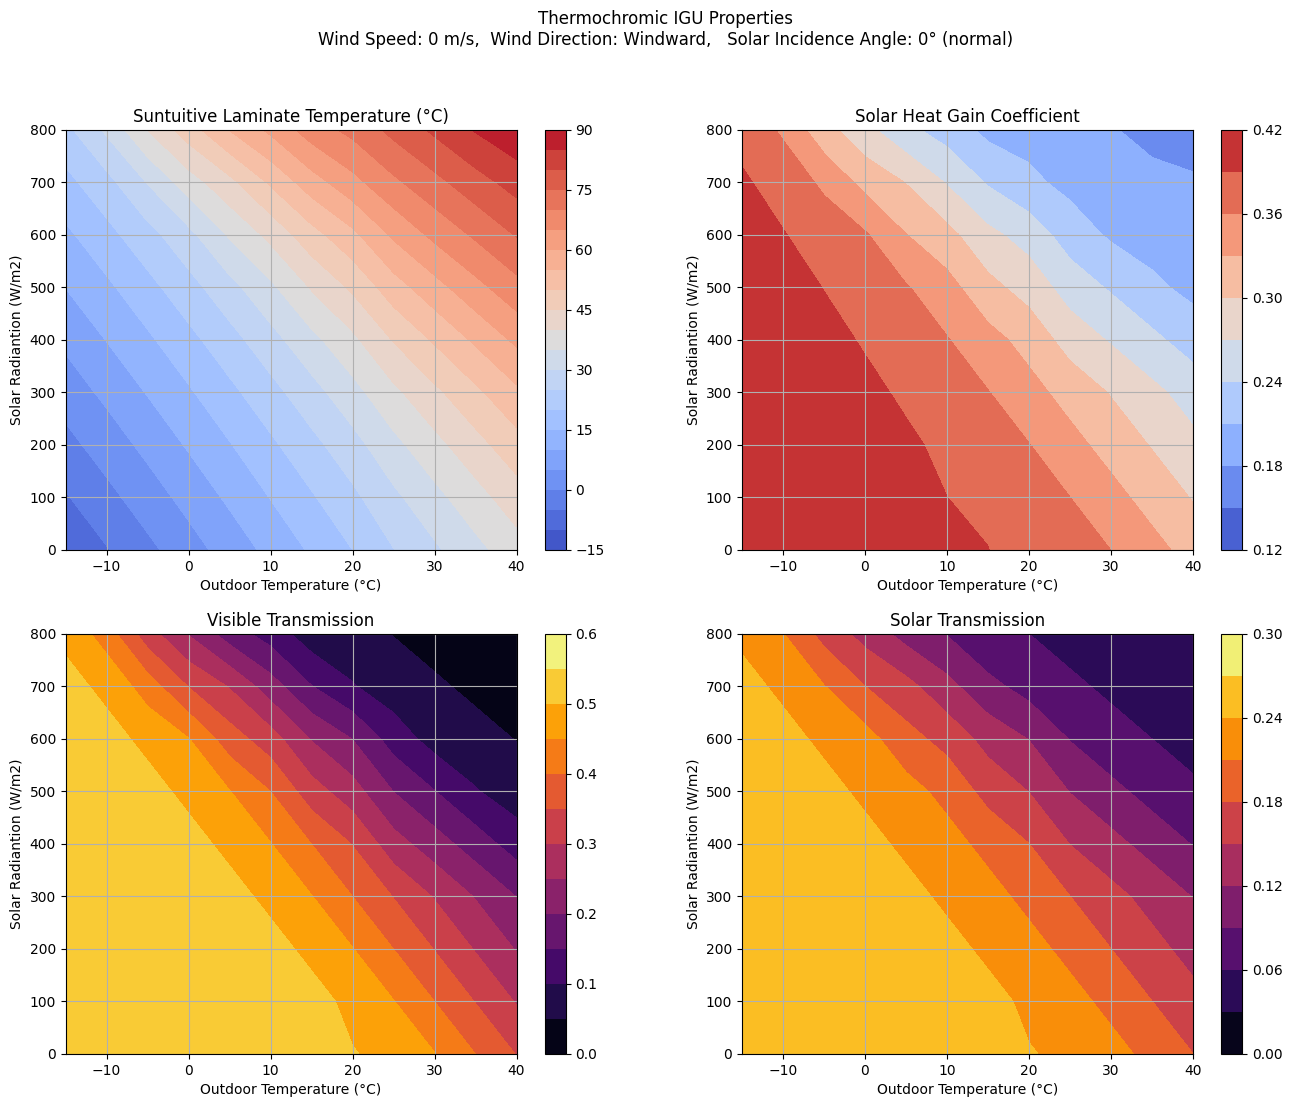

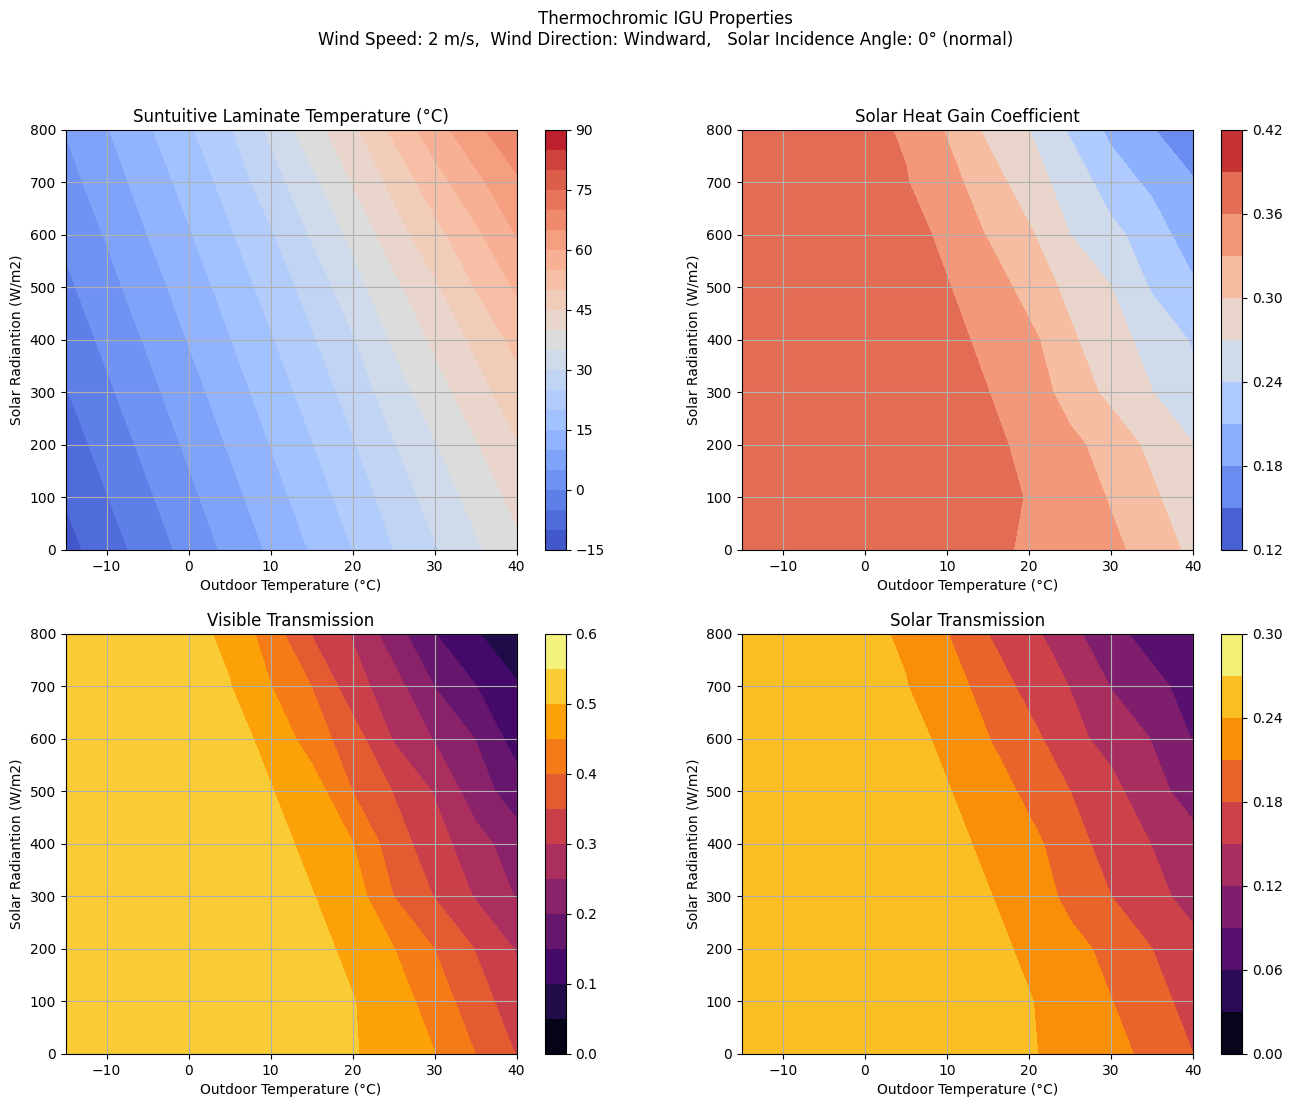

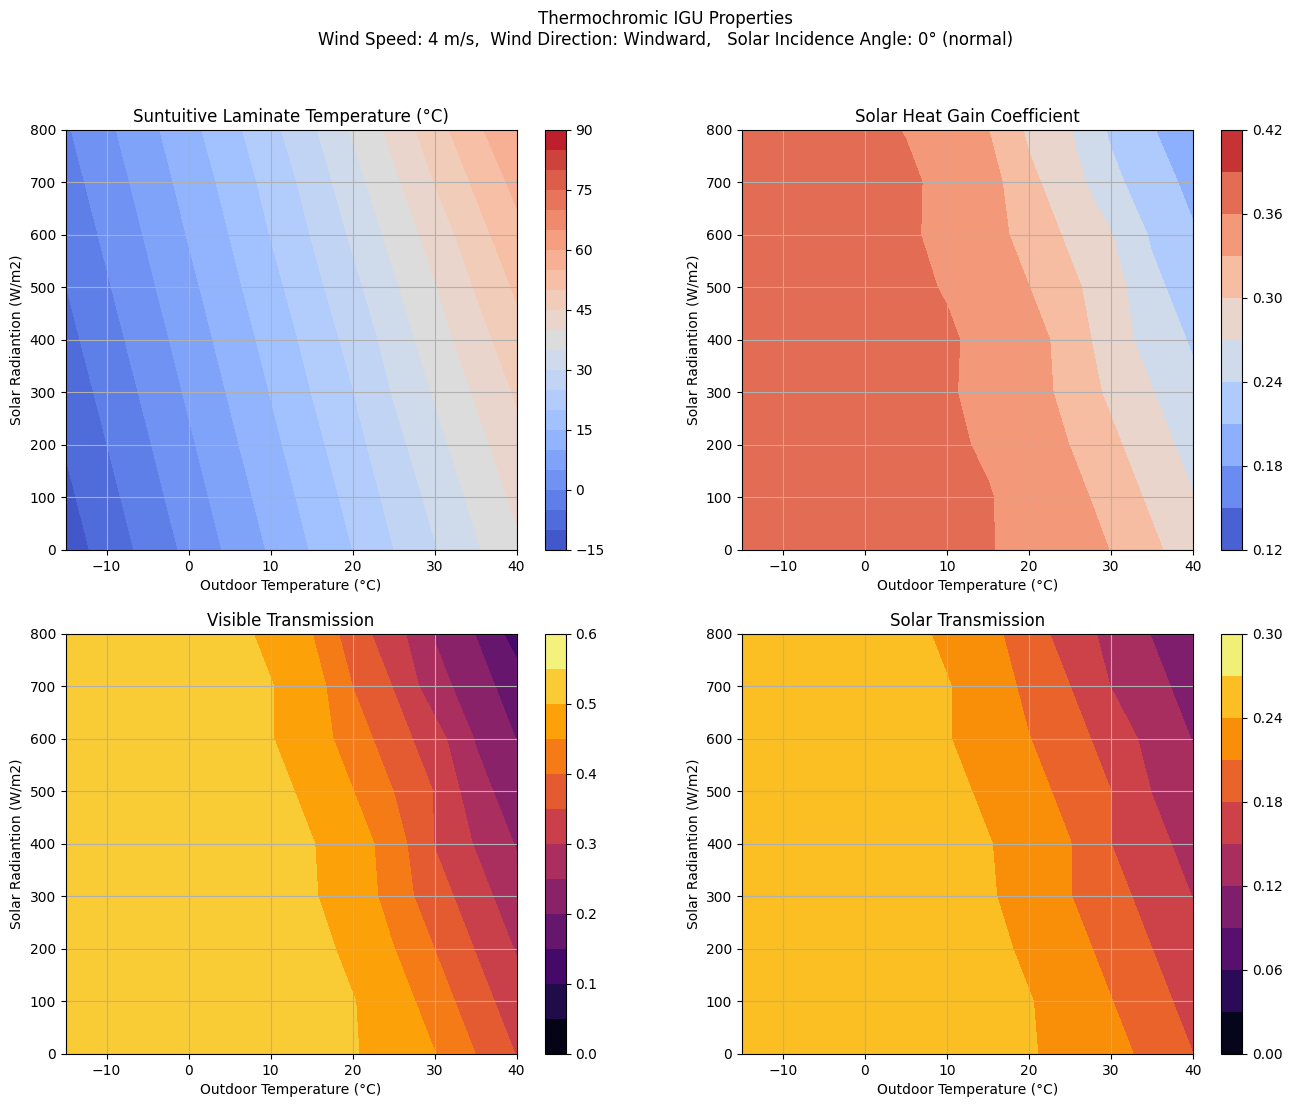

In [16]:
interior_lite = Cardinal_LoE272

#ranges for looping to generate plots of IGU properties for various exterior temperatures and radiations.
temperature_range = [ t for t in range(-15,45,5) ]
radiation_range = [ r for r in range(0,900,100) ]

#loop through a few windspeeds for exterior environment
for windspeed in [0, 2, 4]:
    #create empty results list to populate
    results = []
    #loop though exterior temperatures and radiation values
    for temp_c in temperature_range:
        for rad_w in radiation_range:
            
            # Create environment with temp, windspeed, and radiation
            this_environment = generate_environment(
                exterior_temperature=temp_c, 
                wind_speed=windspeed, 
                wind_direction=pywincalc.AirHorizontalDirection.WINDWARD,
                direct_solar_radiation=rad_w if rad_w>0 else 0.1)


            # Find equilibritum thermochromic temperature, and center of IGU properties and append to results.
            z_temp, z_tvis, z_tsol, z_shgc = determine_thermochromic_conditions(
                                                pywincalc_environment=this_environment,
                                                thermochromic_temperature_list=thermochromic_temperature_list, 
                                                thermochromic_layer_list=thermochromic_layer_list,
                                                interior_lite=interior_lite,
                                                gap=gap_127argon90
                                            )
            results.append([temp_c, rad_w, z_temp, z_tvis, z_tsol, z_shgc])
   
    #From here on is generating plots
    #separate out values from results for plotting
    x_temp, y_irrad, z_temp, z_tvis, z_tsol, z_shgc = np.array( list(zip(*results)))

    #reshape arrays based on number of temperatues and radiations calculated.
    x_temp = x_temp.reshape(len(temperature_range),len(radiation_range))
    y_irrad = y_irrad.reshape(len(temperature_range),len(radiation_range))
    z_temp = z_temp.reshape(len(temperature_range),len(radiation_range))
    z_tvis = z_tvis.reshape(len(temperature_range),len(radiation_range))
    z_tsol = z_tsol.reshape(len(temperature_range),len(radiation_range))
    z_shgc = z_shgc.reshape(len(temperature_range),len(radiation_range))

    # setting colormap ranges
    temp_min = -15
    temp_max = 90
    temp_itr = 5
    norm_temp = mcolors.Normalize(vmin=temp_min, vmax=temp_max)
    tvis_min = 0
    tvis_max = 0.60
    tvis_itr = 0.05
    norm_tvis = mcolors.Normalize(vmin=tvis_min, vmax=tvis_max)
    tsol_min = 0.00
    tsol_max = 0.30
    tsol_itr = 0.03
    norm_tsol = mcolors.Normalize(vmin=tsol_min, vmax=tsol_max)
    shgc_min = 0.12
    shgc_max = 0.42
    shgc_itr = 0.03
    norm_shgc = mcolors.Normalize(vmin=shgc_min, vmax=shgc_max)

    # generate a 2x2 plot
    fig,axes = plt.subplots(2,2,figsize=(16,12))
    plt.suptitle(f"Thermochromic IGU Properties\nWind Speed: {windspeed} m/s,  Wind Direction: Windward,   Solar Incidence Angle: 0° (normal)")
    for axe in axes:
        for ax in axe:
            ax.set_xlabel("Outdoor Temperature (°C)")
            ax.set_ylabel("Solar Radiantion (W/m2)")
            ax.grid(True)

    axes[0][0].set_title("Suntuitive Laminate Temperature (°C)")
    axes[1][0].set_title("Visible Transmission")
    axes[1][1].set_title("Solar Transmission")
    axes[0][1].set_title("Solar Heat Gain Coefficient")

    contourf_temp = axes[0][0].contourf(x_temp, y_irrad, z_temp,
                                     levels=[i for i in range(temp_min,temp_max+temp_itr,temp_itr)], 
                                     cmap=plt.cm.coolwarm, norm=norm_temp)

    contourf_tvis = axes[1][0].contourf(x_temp, y_irrad, z_tvis,
                                    levels=[ sg for sg in np.arange(tvis_min, tvis_max+tvis_itr, tvis_itr)], 
                                    cmap=plt.cm.inferno, norm=norm_tvis)
    
    contourf_tsol = axes[1][1].contourf(x_temp, y_irrad, z_tsol,
                                    levels=[ sg for sg in np.arange(tsol_min, tsol_max+tsol_itr, tsol_itr)], 
                                    cmap=plt.cm.inferno, norm=norm_tsol)  
    
    contourf_shgc = axes[0][1].contourf(x_temp, y_irrad, z_shgc,
                                    levels=[ sg for sg in np.arange(shgc_min, shgc_max+shgc_itr, shgc_itr)], 
                                    cmap=plt.cm.coolwarm, norm=norm_shgc)

    fig.colorbar(contourf_temp)
    contourf_temp.set_clim(temp_min,temp_max)
    fig.colorbar(contourf_tvis)
    contourf_tvis.set_clim(tvis_min,tvis_max)
    fig.colorbar(contourf_tsol)
    contourf_tsol.set_clim(tsol_min,tsol_max)
    fig.colorbar(contourf_shgc)
    contourf_shgc.set_clim(shgc_min, shgc_max)

    plt.show()
    fig.set_facecolor('#ffffff')
    fig.savefig(f"plots/Thermochromic_Temp+SHGC_ws{windspeed}_LoE272.png", dpi=300, bbox_inches='tight')

## Run annual simulation using weather data for Chicago

### Load weatherdata

In [19]:
chicago_epw=epw()
chicago_epw.read('USA_IL_Chicago-OHare.Intl.AP.725300_TMY3/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw')

In [20]:
site_latitude = float(chicago_epw.headers['LOCATION'][5])
site_longitude = float(chicago_epw.headers['LOCATION'][6])
site_latitude, site_longitude

(41.98, -87.92)

### Creating a class for a thermochromic facade

In [21]:
class thermochromic_facade:
    def __init__(self,
                site_latitude,
                site_longitude,
                facade_orientation,
                facade_tilt,
                timezone,
                interior_lite,
                gap,
                thermochromic_temperature_list,
                thermochromic_layer_list
                ):
        self.site_latitude = site_latitude
        self.site_longitude = site_longitude
        self.timezone = timezone
        self.facade_orientation = facade_orientation
        self.facade_tilt = facade_tilt
        self.interior_lite = interior_lite
        self.gap = gap
        self.pysolar_version = version("pysolar")
        
        # facade vectors in cartesean space:
        self.normal_xyz = self.ang2xyz(self.facade_orientation, 90-self.facade_tilt)
        self.facade_up_xyz = self.ang2xyz(self.facade_orientation, 180-self.facade_tilt)
        
        # Define translation to facade coordinate system, v=outward facing normal to facade, 
        # w=up(projected into facade if sloped), 
        # u=along facade to the right facing out (perpindicular to v&w)
        v = self.normal_xyz
        w = self.facade_up_xyz
        u = self.ang2xyz(self.facade_orientation+90,0)
        
        # Basis conversion matrices between site (xyz) and facade (uvw) coordinates.
        self.xyz2uvw = np.array([u,v,w]).transpose()
        self.uvw2xyz = np.linalg.inv(self.xyz2uvw)

        # This function creates copies of the thermochromic temperature and layer lists in the object when initialized.
        if len(thermochromic_temperature_list) != len(thermochromic_layer_list):
            print('thermochromic_temperature_list and thermochromic_layer_list must be the same length')
        self.thermochromic_temperature_list = [ i for i in thermochromic_temperature_list ]
        self.thermochromic_layer_list = [ j for j in thermochromic_layer_list ]
        
    #function to get sun position for provided day and time
    def sun_position(self, year, month, day, hour, minute):
        #create datetime object
        self.timestep = datetime.datetime(int(year),int(month),int(day),int(hour)-1,int(minute)+30,0, 0, self.timezone)
        
        # check sunrise and sunset for the day.
        # if the time is more than 30 minutes before sunrise, use the end of the hour instead of the middle.
        # if the time is more than 30 minutes after sunset, use the beginning of the hour instead of the middle.
        # (this avoids instances where there is direct solar radiation but the sun is below the horizon)
        sunrise, sunset = pysolar.util.get_sunrise_sunset(self.site_latitude, self.site_longitude, self.timestep)
        if hour < 12 and sunrise - self.timestep < datetime.timedelta(minutes=30):
            self.timestep = self.timestep + datetime.timedelta(minutes=30)
        if hour > 12 and self.timestep - sunset < datetime.timedelta(minutes=30):
            self.timestep = self.timestep - datetime.timedelta(minutes=30)
        self.solar_altitude = pysolar.solar.get_altitude(self.site_latitude, self.site_longitude, self.timestep)
        self.solar_azimuth = pysolar.solar.get_azimuth(self.site_latitude, self.site_longitude, self.timestep)
        
        #fix for older version of pysolar where the solar azimuth is defined from south instead of north.
        if self.pysolar_version == '0.7':
            self.solar_azimuth = -180 - self.solar_azimuth

        #adjust azimuth to be in range 0-360
        while self.solar_azimuth<0: self.solar_azimuth += 360
        while self.solar_azimuth>360: self.solar_azimuth -= 360

    # calculate solar angles relative to the facade for provided day and time
    def facade_angles(self, year, month, day, hour, minute):
        #firs get sun position
        self.sun_position(year, month, day, hour, minute)

        #vectors in site coordinate system
        site_solar_xyz = self.ang2xyz(self.solar_azimuth, self.solar_altitude)
        dot=self.normal_xyz[0]*site_solar_xyz[0]+self.normal_xyz[1]*site_solar_xyz[1]+self.normal_xyz[2]*site_solar_xyz[2]
        self.facade_solar_theta = math.degrees(math.acos(dot))
        if self.facade_solar_theta > 90:
            self.facade_solar_theta = 90
        if self.solar_altitude < 0:
            self.facade_solar_theta = 90

        facade_solar_uvw = np.linalg.solve(self.xyz2uvw, np.array(site_solar_xyz))
        self.facade_solar_phi = math.degrees(math.acos(
            facade_solar_uvw[0] / math.sqrt(facade_solar_uvw[1]**2 + facade_solar_uvw[0]**2)))
        self.facade_solar_azimuth = math.degrees(math.atan2(facade_solar_uvw[0],facade_solar_uvw[1]))
        self.facade_solar_profile = math.degrees(math.atan2(facade_solar_uvw[2],facade_solar_uvw[1]))
        #print(facade_solar_uvw, self.facade_solar_azimuth, self.facade_solar_profile)

    def generate_environment(self, exterior_temperature, wind_speed, wind_direction, direct_solar_radiation):
        ### Note: Diffuse radiation is ignored because pywincalc doesn't have a means to include diffuse radiation in the environment.
        #set interior temperature based on exterior temperature.
        if exterior_temperature<20:
            interior_temperature = 20 # if exterior is below 20, inteior is 20
        elif exterior_temperature>24:
            interior_temperature = 24 # if exterior is above 24, interior is 24
        else:
            interior_temperature = exterior_temperature # if exterior is between 20 and 24, interior=exterior

        #Define interior environment
        inside_environment = pywincalc.Environment(
                air_temperature = interior_temperature + 273.15,
                pressure = 101325.0,
                convection_coefficient = 0.0,
                coefficient_model = pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
                radiation_temperature = interior_temperature + 273.15,
                emissivity = 1.0,
                air_speed = 0.0,
                air_direction = pywincalc.AirHorizontalDirection.NONE,
                direct_solar_radiation = 0.0
            )

        # Define exterior environment
        outside_environment = pywincalc.Environment(
                air_temperature = exterior_temperature + 273.15,
                pressure = 101325.0,
                convection_coefficient = 26.0,
                coefficient_model = pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
                radiation_temperature = exterior_temperature + 273.15,
                emissivity = 1.0,
                air_speed = wind_speed,
                air_direction = wind_direction,
                direct_solar_radiation = direct_solar_radiation + 0.01
            )

        # Combine interior an exterior environment 
        self.custom_environmental_conditions = pywincalc.Environments(outside_environment, inside_environment)
    
    def determine_timestep_properties(self, year, month, day, hour, minute, 
                                      exterior_temperature, wind_speed, wind_direction, direct_solar_radiation ):
        # Update facade angles for current timestep
        self.facade_angles(year, month, day, hour, minute)

        # Determine if facade is windward or leeward
        wind_facade_angle = abs(wind_direction - self.facade_orientation)
        if wind_facade_angle <= 90 or wind_facade_angle >=270:
            direction = pywincalc.AirHorizontalDirection.WINDWARD
        else:
            direction = pywincalc.AirHorizontalDirection.LEEWARD

        # Update environment for current timestep
        self.generate_environment(exterior_temperature, wind_speed, direction, direct_solar_radiation)

        # Create empty lists for glazing systems and calculated layer temperatures
        glazing_systems=[]
        layer_temps=[]

        # Make local copies of list
        local_thermochromic_temperature_list = [ temp for temp in self.thermochromic_temperature_list
                                                 if temp+2.5 > exterior_temperature ] 
        local_thermochromic_layer_list = [ self.thermochromic_layer_list[i] for i in range(len(self.thermochromic_temperature_list))
                                           if self.thermochromic_temperature_list[i]+2.5 > exterior_temperature ] 
        
        #loop though temperatures that remain in the temperature list
        for i in range(len(local_thermochromic_temperature_list)):
            
            #create a glazing system with the provided environmental conditions and optical properties for a laminate temperature
            glazing_systems.append(pywincalc.GlazingSystem(
                environment=self.custom_environmental_conditions,
                solid_layers=[local_thermochromic_layer_list[i],
                              self.interior_lite
                             ],
                gap_layers=[self.gap]))
            
            #flip the interior lite if the low emissivity layer is not on the front
            if self.interior_lite.emissivity_front > 0.5:
                glazing_systems[i].flip_layer(1,True)
            
            #this is so that the shgc calc includes the sun (workaroud for a current pywincalc bug).
            glazing_systems[i].u(1,1)
            
            #check the calculated layer temperatures and
            #take average of surface 1 and surface 2 temprature to determine thermochromic temperature
            this_layer_temps = glazing_systems[i].layer_temperatures(pywincalc.TarcogSystemType.SHGC, theta=self.facade_solar_theta,
                                                phi=self.facade_solar_phi)
            layer_temps.append((this_layer_temps[0]+this_layer_temps[1])/2 - 273.15)
            
            #if the calculated temperature is below the temperature of the optical properties, we can break the loop
            if layer_temps[i] < local_thermochromic_temperature_list[i]:
                break
    
        # some logic to get the properties of the calculation where the calculated thermochromic temperature is closest
        # to the temperature of the optical properties 
        if len(layer_temps) == 1:
            this_temp = layer_temps[0]
            this_shgc = glazing_systems[0].shgc(theta=self.facade_solar_theta,
                                                phi=self.facade_solar_phi)
            this_tvis = glazing_systems[0].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
            this_tsol = glazing_systems[0].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
        else:
            if abs(layer_temps[-2] - local_thermochromic_temperature_list[-2]) < \
                abs(layer_temps[-1] - local_thermochromic_temperature_list[-1]):
                this_temp = layer_temps[-2]
                this_shgc = glazing_systems[-2].shgc(theta=self.facade_solar_theta,
                                                phi=self.facade_solar_phi)
                this_tvis = glazing_systems[-2].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
                this_tsol = glazing_systems[-2].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
            else:
                this_temp = layer_temps[-1]
                this_shgc = glazing_systems[-1].shgc(theta=self.facade_solar_theta,
                                                phi=self.facade_solar_phi)
                this_tvis = glazing_systems[-1].optical_method_results("PHOTOPIC").system_results.front.transmittance.direct_direct
                this_tsol = glazing_systems[-1].optical_method_results("SOLAR").system_results.front.transmittance.direct_direct
        
        return([this_temp, this_tvis, this_tsol, this_shgc])
    
    def ang2xyz(self, azi, alt):
        z=math.sin(math.radians(alt))
        y=math.cos(math.radians(alt))*math.cos(math.radians(azi))
        x=math.cos(math.radians(alt))*math.sin(math.radians(azi))
        return([x,y,z])


### Instantiate a facade for South (using Cardinal LoE180 & 90% argon gap)

In [22]:
chicago_south = thermochromic_facade(   site_latitude=site_latitude, 
                                        site_longitude=site_longitude, 
                                        facade_orientation=180, 
                                        facade_tilt=90, 
                                        timezone=pytz.timezone('America/Chicago'),
                                        interior_lite=Cardinal_LoE272,
                                        gap=gap_127argon90,
                                        thermochromic_temperature_list=thermochromic_temperature_list,
                                        thermochromic_layer_list=thermochromic_layer_list
                                    )

chicago_west = thermochromic_facade(   site_latitude=site_latitude, 
                                        site_longitude=site_longitude, 
                                        facade_orientation=270, 
                                        facade_tilt=90, 
                                        timezone=pytz.timezone('America/Chicago'),
                                        interior_lite=Cardinal_LoE272,
                                        gap=gap_127argon90,
                                        thermochromic_temperature_list=thermochromic_temperature_list,
                                        thermochromic_layer_list=thermochromic_layer_list
                                    )

### Run simulations (this takes time)

In [23]:
# create empty list for results
chicago_south_results = []
chicago_west_results = []

# loop through weather data one hour at a time
for index, row in chicago_epw.dataframe.iterrows():
    this_temp, this_tvis, this_tsol, this_shgc = chicago_south.determine_timestep_properties(
                                                        row['Year'], row['Month'], row['Day'], row['Hour'], row['Minute'],
                                                        exterior_temperature=row['Dry Bulb Temperature'],
                                                        wind_speed=row['Wind Speed'], 
                                                        wind_direction=row['Wind Direction'],
                                                        direct_solar_radiation=row['Direct Normal Radiation'],
                                                    )
    # Append results list with results for this hour.
    chicago_south_results.append([row['Month'],
                                  row['Day'],
                                  row['Hour'],
                                  row['Minute'],
                                  row['Direct Normal Radiation'],
                                  this_temp,
                                  this_tvis,
                                  this_tsol,
                                  this_shgc,
                                  chicago_south.facade_solar_theta,
                                  chicago_south.facade_solar_phi])

for index, row in chicago_epw.dataframe.iterrows():
    this_temp, this_tvis, this_tsol, this_shgc = chicago_west.determine_timestep_properties(
                                                        row['Year'], row['Month'], row['Day'], row['Hour'], row['Minute'],
                                                        exterior_temperature=row['Dry Bulb Temperature'],
                                                        wind_speed=row['Wind Speed'], 
                                                        wind_direction=row['Wind Direction'],
                                                        direct_solar_radiation=row['Direct Normal Radiation'],
                                                    )
    # Append results list with results for this hour.
    chicago_west_results.append([row['Month'],
                                  row['Day'],
                                  row['Hour'],
                                  row['Minute'],
                                  row['Direct Normal Radiation'],
                                  this_temp,
                                  this_tvis,
                                  this_tsol,
                                  this_shgc,
                                  chicago_west.facade_solar_theta,
                                  chicago_west.facade_solar_phi])

#### Save & load results:

In [24]:
#Save results to file so that we don't have to run it again
with open('saved_results/chicago_south_thermochromic_LoE272.pkl', 'wb') as f:
    pickle.dump(chicago_south_results, f)
with open('saved_results/chicago_west_thermochromic_LoE272.pkl', 'wb') as f:
    pickle.dump(chicago_west_results, f)

In [25]:
#use this to load results from file
with open('saved_results/chicago_south_thermochromic_LoE272.pkl', 'rb') as f:
    chicago_south_results = pickle.load(f)
with open('saved_results/chicago_west_thermochromic_LoE272.pkl', 'rb') as f:
    chicago_west_results = pickle.load(f)

### Plotting Results

In [26]:
# A function  to create an annual plot from results
def annual_plot(x_array, y_array, z_array, vmin, vmax, vincr, colormap, plot_title, cbar_label, cbar_scale='linear'):
    if cbar_scale=='linear':
        norm_temp = mcolors.Normalize(vmin=vmin, vmax=vmax)
    else:
        norm_temp = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    fig,ax = plt.subplots(1,1,figsize=(16,6))
    ax.set_title(plot_title)
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Hour of Day")
    ax.set_xticks([0,31,59,90,120,151,181,212,243,273,304,334,365])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',''])
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    ax.set_yticks([0,3,6,9,12,15,18,21,24])
    ax.grid(True)
    contourf_ = ax.contourf(x_array,
                            y_array,
                            z_array,
                            [i for i in np.arange(vmin, vmax+vincr, vincr)], vmin=vmin, vmax=vmax, cmap=colormap, norm=norm_temp)
    
    cbar = fig.colorbar(contourf_)
    contourf_.set_clim(vmin, vmax)
    cbar.set_label(cbar_label)
    
    plt.show()
    fig.set_facecolor('#ffffff')
    return(fig)

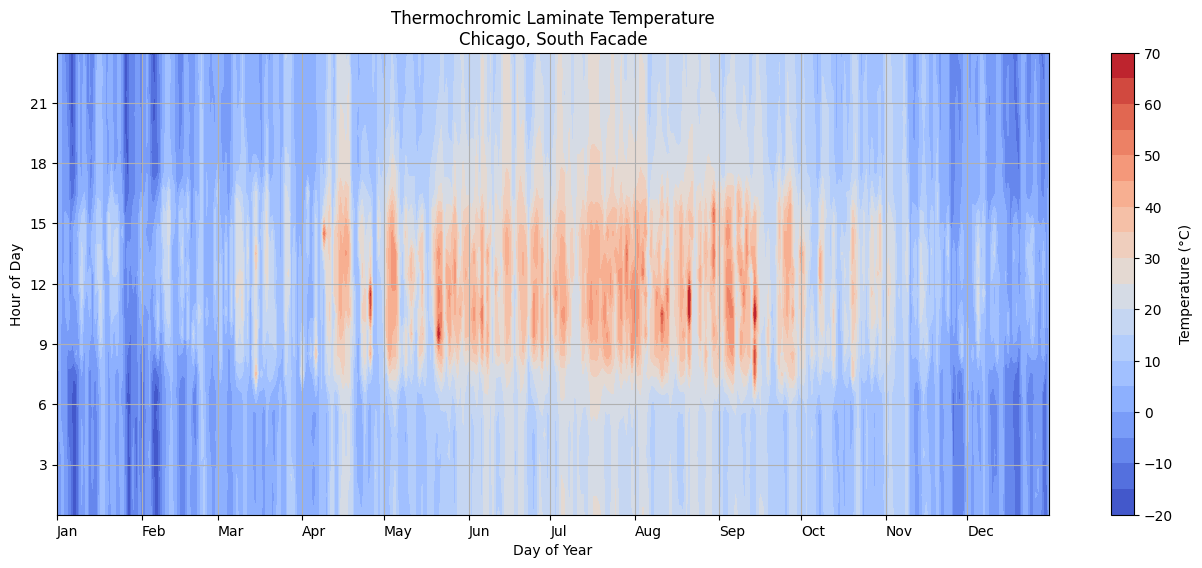

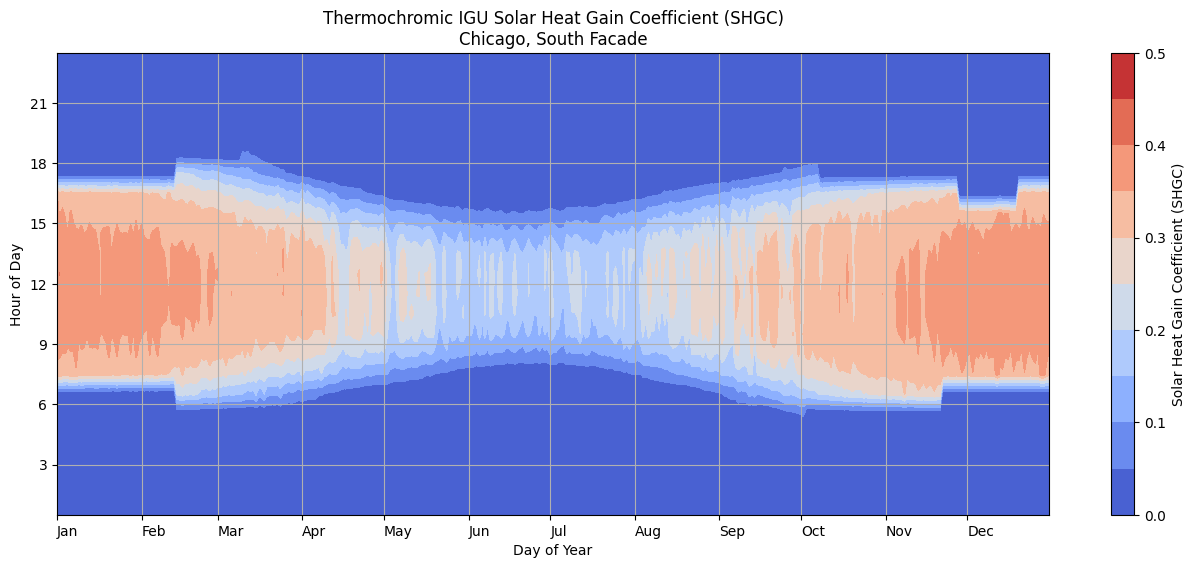

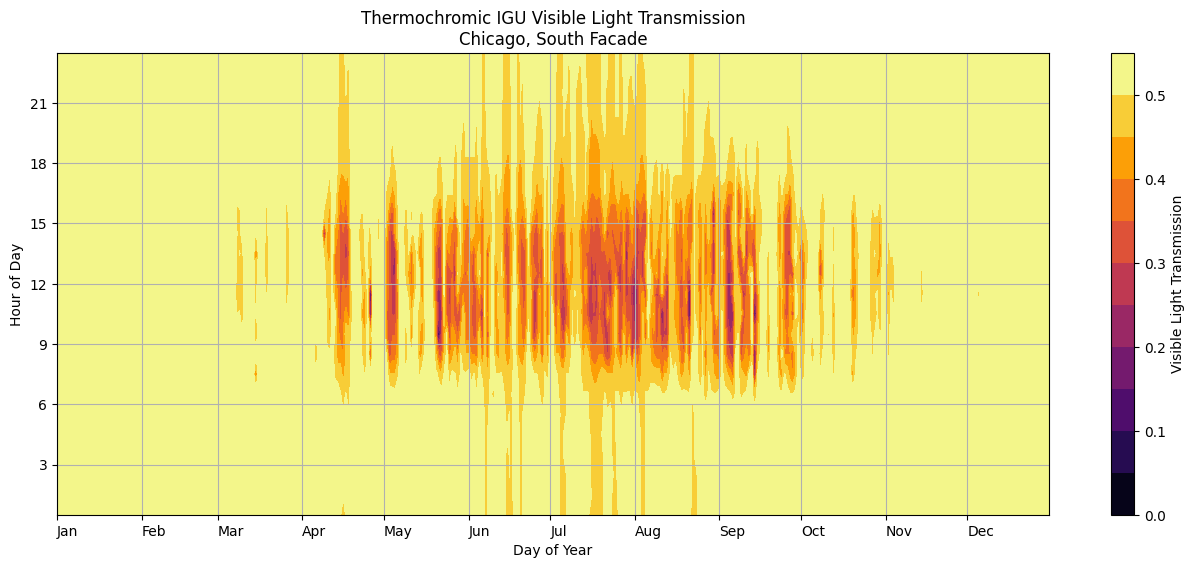

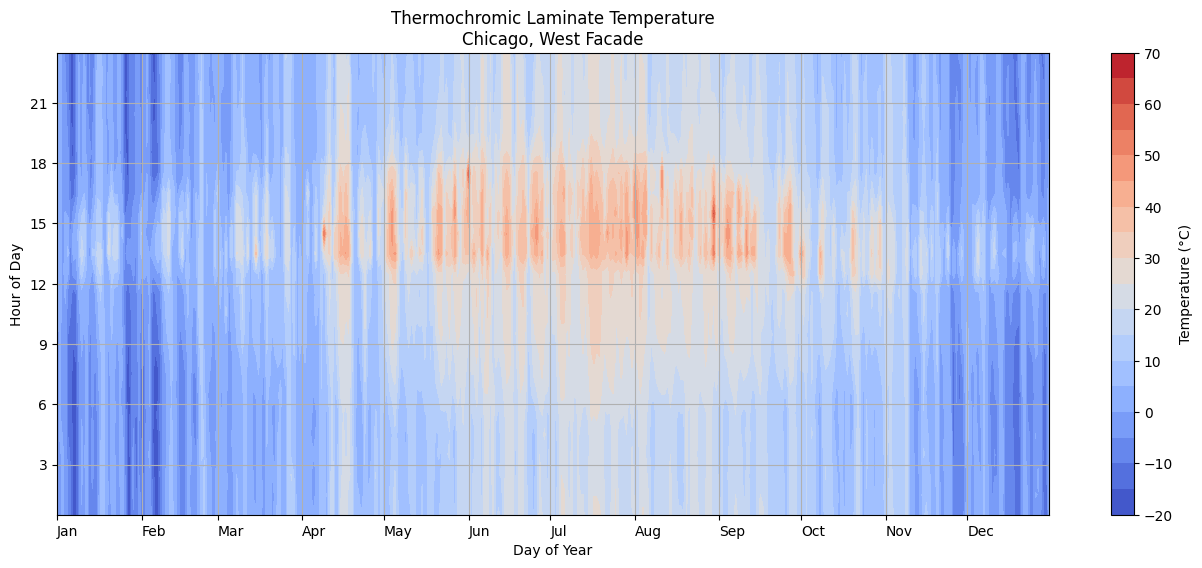

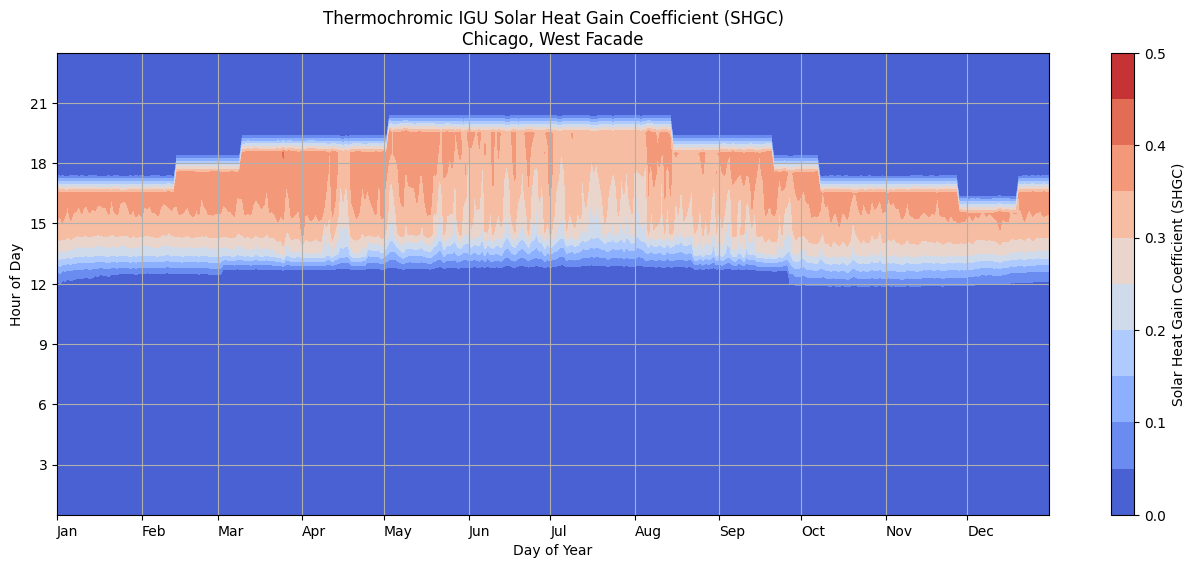

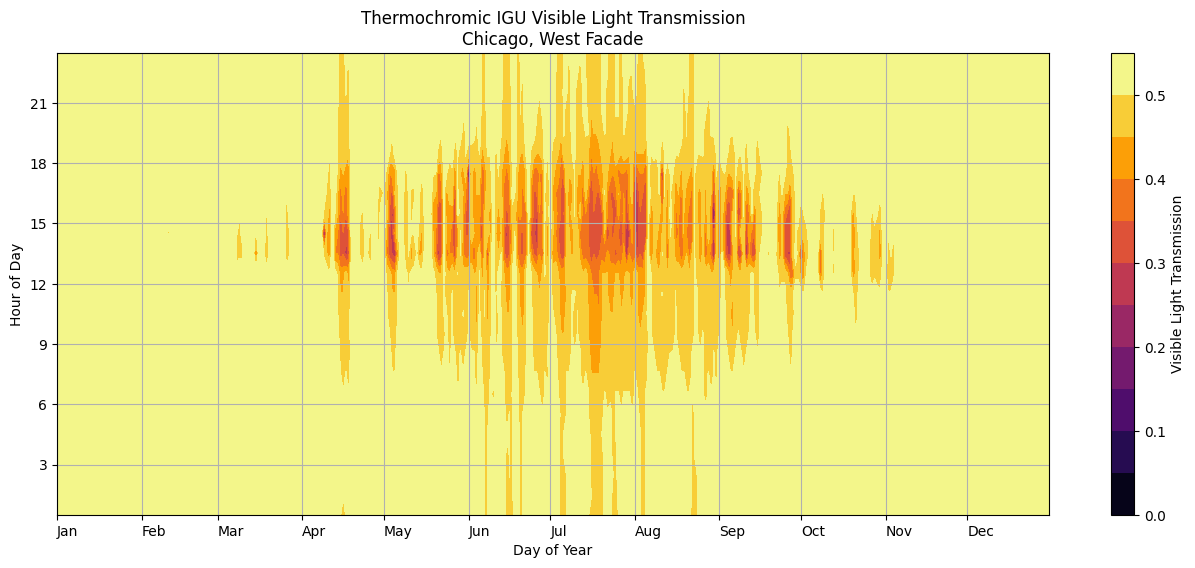

In [27]:
#create lists for facades and results
facades = ['South', 'West']
facade_results = [chicago_south_results, chicago_west_results]

#For each facade creat plots
for i in range(len(facades)):
    ar_month, ar_day, hour, ar_minute, ar_DNI, z_layer_temp, z_tvis, z_tsol, z_shgc, ar_theta, ar_phi = \
                                                                np.array( list(zip(*facade_results[i])))
    y_hour = hour-0.5
    x_jd = np.array([ math.floor(i/24) for i in range(len(y_hour))])
    
    #### LAYER TEMPERATURE PLOT ##########################################
    annual_plot(x_jd.reshape(365,24),
                y_hour.reshape(365,24),
                z_layer_temp.reshape(365,24),
                vmin=-20,
                vmax=70,
                vincr=5,
                colormap=plt.cm.coolwarm,
                plot_title=f"Thermochromic Laminate Temperature\nChicago, {facades[i]} Facade",
                cbar_label='Temperature (°C)'
               ).savefig(f"Plots/Annual_Thermochromic_Temperature_Chicago_{facades[i]}_LoE272.png", dpi=300, bbox_inches='tight')


    #### SHGC PLOT #######################################################
    annual_plot(x_jd.reshape(365,24),
                y_hour.reshape(365,24),
                z_shgc.reshape(365,24),
                vmin=0.00,
                vmax=0.50,
                vincr=0.05,
                colormap=plt.cm.coolwarm,
                plot_title=f"Thermochromic IGU Solar Heat Gain Coefficient (SHGC)\nChicago, {facades[i]} Facade",
                cbar_label='Solar Heat Gain Coefficient (SHGC)'
               ).savefig(f"Plots/Annual_Thermochromic_SHGC_Chicago_{facades[i]}LoE272.png", dpi=300, bbox_inches='tight')

    #### Tvis PLOT #######################################################
    annual_plot(x_jd.reshape(365,24),
                y_hour.reshape(365,24),
                z_tvis.reshape(365,24),
                vmin=0.00,
                vmax=0.54,
                vincr=0.05,
                colormap=plt.cm.inferno,
                plot_title=f"Thermochromic IGU Visible Light Transmission\nChicago, {facades[i]} Facade",
                cbar_label='Visible Light Transmission'
               ).savefig(f"Plots/Annual_Thermochromic_Tvis_Chicago_{facades[i]}LoE272.png", dpi=300, bbox_inches='tight')
